In [19]:
import pandas as pd
import os
import glob
from astropy.utils.data import get_pkg_data_filename
from astropy.io import fits
from astropy.table import Table
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import numpy as np
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import warnings
import pandas as pd
import os
import glob
from astropy.utils.data import get_pkg_data_filename
from astropy.io import fits
from astropy.table import Table
import scipy as scipy
from scipy import optimize
from scipy.optimize import differential_evolution

In [2]:
hdulist = fits.open('../data/composite_Io_eclipsed.fits')
evt_data = Table(hdulist[1].data)
image_data = hdulist[1].data
df = pd.read_csv('../data/Io_Master_Line_List (1).csv') #spaces in csv file will make df object type and not float64
line = "S I"
target_mask = df.Species.str.endswith(line) #probably a better function but idk it right now
df = df[target_mask]
df_wavelength = df['Wavelength']
df_species = df['Species']

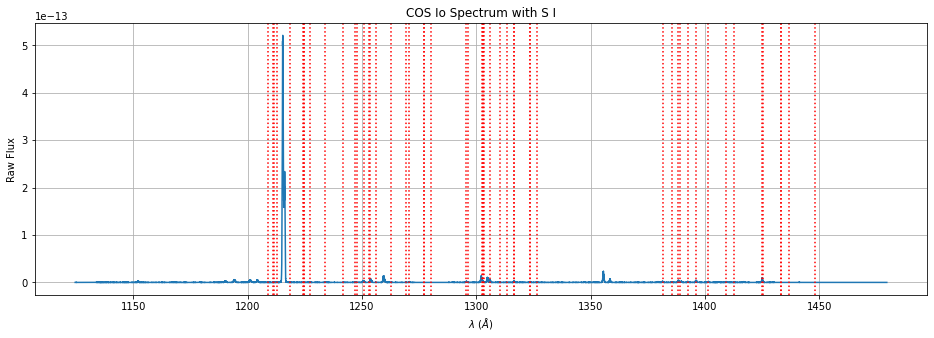

In [3]:
plt.figure(figsize=(16, 5))
plt.plot(evt_data['WAVELENGTH'].T, evt_data['FLUX'].T) #make it columns instead of rows bc otherwise will be a blank plot
plt.xlabel('$\lambda$ ($\AA$)');
plt.ylabel('Raw Flux')
plt.title("COS Io Spectrum with S I")
for xc in df_wavelength:
    plt.axvline(x=xc, color = 'red', linestyle = 'dotted')
plt.grid(True) 

In [17]:
def gaussian(x, mu, sig, A):
    return A*np.exp(-(x-mu)**2/(2*sig**2))

In [18]:
array = pd.read_csv('../data/least_squares_array.csv') #spaces in csv file will make df object type and not float64
guess = array.to_numpy()

In [22]:
wl = evt_data['WAVELENGTH'].T
flux = evt_data['FLUX'].T
wl = wl.data
flux = flux.data
wl = wl.flatten()
flux = flux.flatten()

In [24]:
C = np.delete(guess, 1, 1)
C = C.tolist()

In [25]:
C[78]

[1396.112, 0.23, 2e-16]

In [26]:
errfunc1 = lambda p, x, y: (gaussian(x, *p) - y)**2
guess1 = C[78]
#guess1 = [1392.588, 0.23, 2E-15]

In [27]:
optim1, success = optimize.leastsq(errfunc1, guess1, args=(wl, flux))

In [28]:
optim1

array([1.39617582e+03, 7.03346718e-01, 1.84678227e-15])

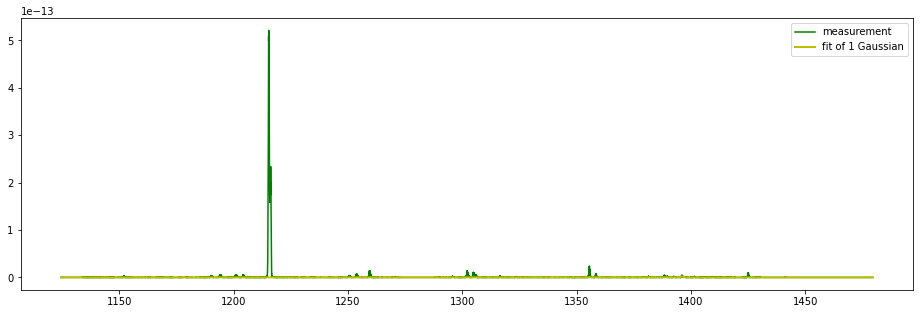

In [29]:
plt.figure(figsize=(16, 5))
plt.plot(wl, flux, c='g', label='measurement')
plt.plot(wl, gaussian(wl, *optim1),
    lw=2, c='y', label='fit of 1 Gaussian')
plt.legend(loc='best')